# Welcome to Machine Learning Housing Corporation!
Your task is to predict median house values in Californian districts, given a number of features from these districts.

## 1. Examine the data

In [18]:
import pandas as pd
ca_housing = "https://raw.githubusercontent.com/csbfx/advpy122-data/master/California_housing.csv"

housing = pd.read_csv(ca_housing)
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [19]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


### Looks like all attributes are numerical, except the `ocean_proximity` field. There are repetitive values in it as well, so it is probably a categorical attribute. We can always use `value_counts()` method to see how many districts belong to each category.

In [20]:
housing["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

### Let's look at the other numerical fields. The `describe()` method show a summary of the numerical attributes.

In [21]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


### Another quick way to get a feel of the type of data you are dealing with is to plot a history for each numerical attribute using the `hist()` method on the whole dataset.

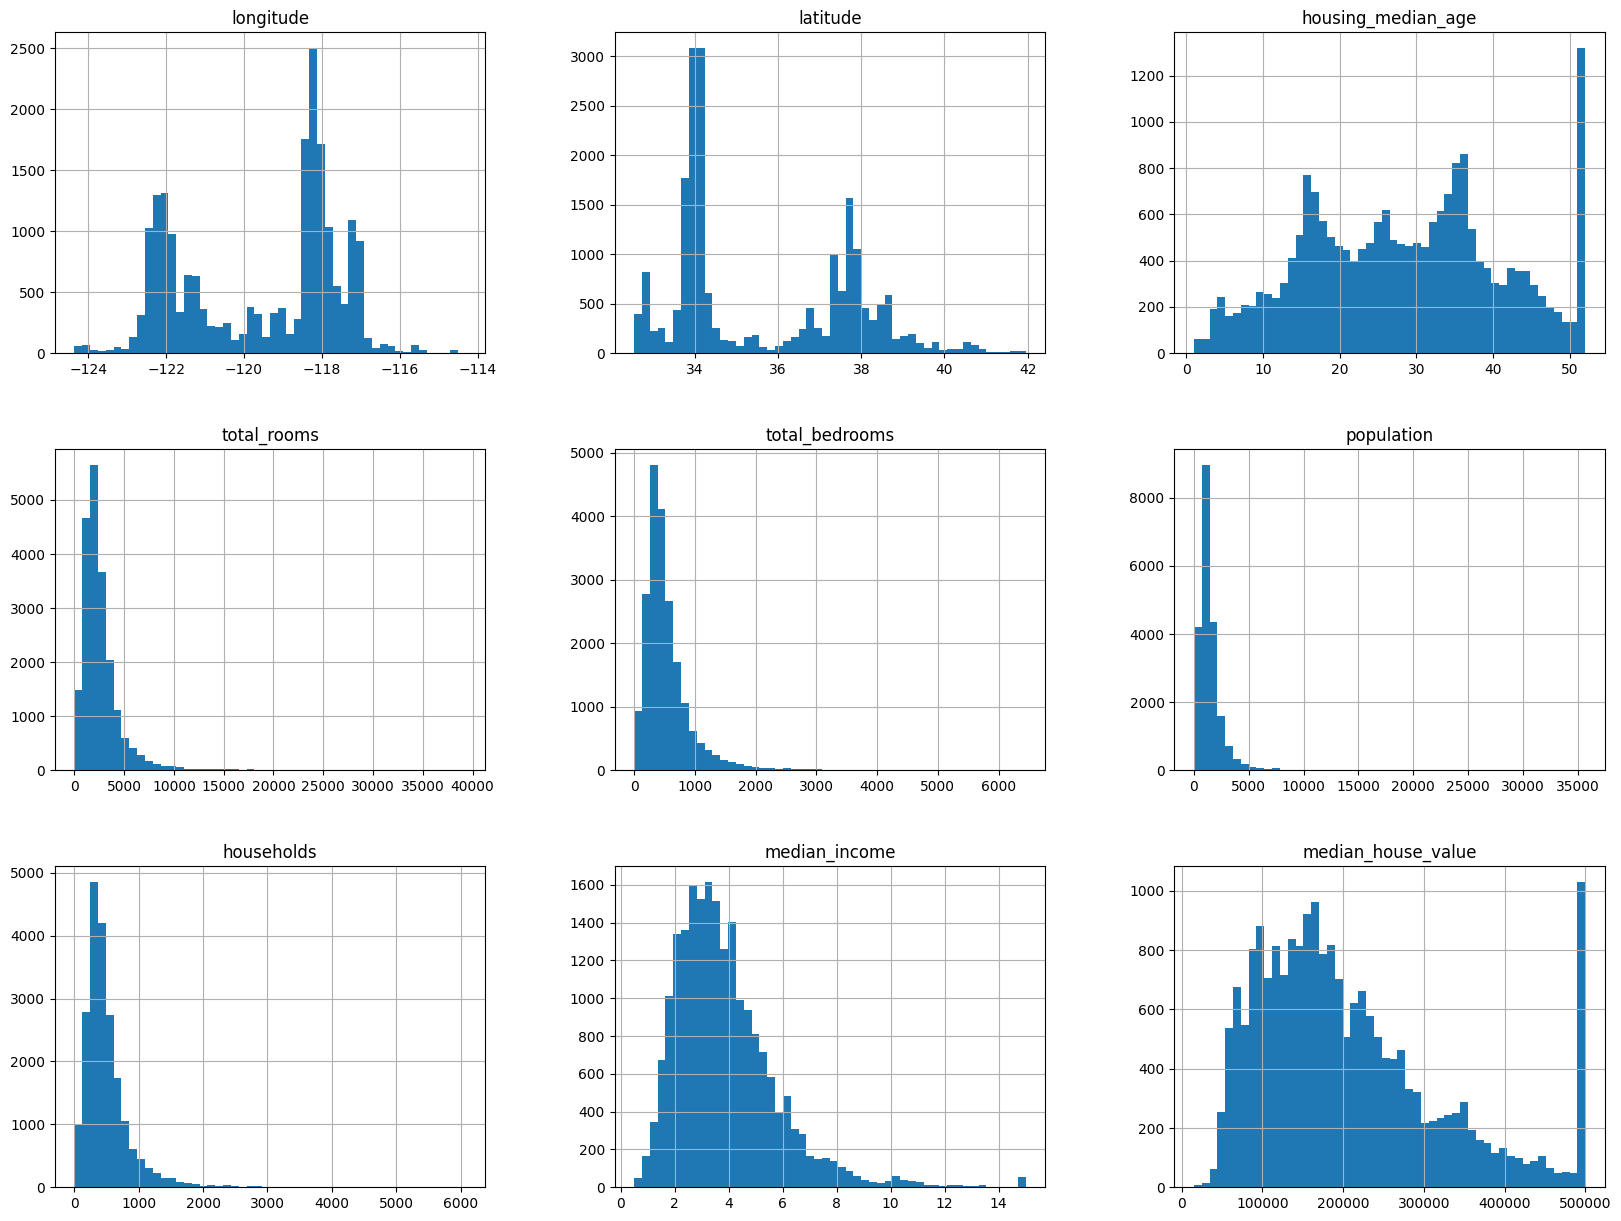

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

### Notice a few things in these histograms:
1. The median income attribute does not look like it's expressed in US dollars (USD). It turns out this data has been scaled and capped at 15.0001 for higher median income, and at 0.4999 for lower median incomes. The number represent roughly tens of thousands of dollars (e.g. 3 actually means about \$30,000).
2. The housing median age and the median house value were also capped. These may become problematic because your ML algorithms may learn that prices never go beyond that limit. If you want to make predictions beyond \$500,000, then you have 2 main options:
    - a) Collect proper labels for the districts whose labels were capped.
    - b) Remove those districts from the training set (and also from the test set, since your system should not be evaluated poorly if it predicts values beyond \$500,000).
3. These attributes have very different scales. We will explore **feature scaling**.
4. Many histograms are *tail heavy*: they extend much farther to the right of the median than to the left. This make it a bit harder for some ML algorithms to detect patterns. We will try **transforming these attributes** to have more bell-shaped distributions.

## 2. Create a Test Set
Our brain is an amazing pattern detection system, which means that it is highly prone to overfitting. If we look at the test set, we might stumble upon some seemingly interesting pattern in the test data that leads us to select a particular kind of ML model. When we estimate the generalization error using the test set, our estimate will be too optimistic and we will launch a system that will not perform as well as expected. This is called __*data snooping*__ bias.

Let's pick some instances randomly, typically 20% of the dataset, and set them aside:

Scikit-Learn provides a few functions to split datasets into multiple subsets in various ways. `train_test_split` is the simpliest function.
- The `random_state` parameter allows you to set the random number generator seed.
- You can pass it multiple datasets with an identical number of rows, and it will split them on the same indices (this is very useful if we have a separate DataFrame for labels):

In [23]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [24]:
train_set

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
14196,-117.03,32.71,33.0,3126.0,627.0,2300.0,623.0,3.2596,103000.0,NEAR OCEAN
8267,-118.16,33.77,49.0,3382.0,787.0,1314.0,756.0,3.8125,382100.0,NEAR OCEAN
17445,-120.48,34.66,4.0,1897.0,331.0,915.0,336.0,4.1563,172600.0,NEAR OCEAN
14265,-117.11,32.69,36.0,1421.0,367.0,1418.0,355.0,1.9425,93400.0,NEAR OCEAN
2271,-119.80,36.78,43.0,2382.0,431.0,874.0,380.0,3.5542,96500.0,INLAND
...,...,...,...,...,...,...,...,...,...,...
11284,-117.96,33.78,35.0,1330.0,201.0,658.0,217.0,6.3700,229200.0,<1H OCEAN
11964,-117.43,34.02,33.0,3084.0,570.0,1753.0,449.0,3.0500,97800.0,INLAND
5390,-118.38,34.03,36.0,2101.0,569.0,1756.0,527.0,2.9344,222100.0,<1H OCEAN
860,-121.96,37.58,15.0,3575.0,597.0,1777.0,559.0,5.7192,283500.0,<1H OCEAN


### Stratified sampling
Purely random sampling methods are generally fine if the dataset is large enough, but if it's not, then we run the risk of introducing a significant sampling bias.

For example:
We will sample 1000 people that represent the US population which is composed of 51.3% female and 48.7% male. To make sure that these 1000 people are representative of the whole population, we will want to maintain the same ratio in the sample: 513 female and 487 male. We will use __*stratified sampling*__: the population is divided into homogeneous subgroups called __*strata*__, and the right number of instances is sampled from each stratum to guarantee that the test set is representative of the overall population.

Another example: Let's say the median income is a very important attribute to predict median house prices. We want to ensure that the test set is representative of the various categories of incomes in the whole dataset. Since the median income is a continuous numerical attribute, we first need to create an income category attritube.

By looking at the histogram above, we see that most median income values are clustered around 1.5 to 6 (ie: \\$15,000-\\$60,000), but some median incomes go far beyond 6.

**It is important to have sufficient number of instances in our dataset for each stratum, or else the estimate of the stratum's importance may be biased.**

Let's create an income category with 5 categories (labeled from 1 to 5): category 1 ranges from 0 to 1.5 (ie: less than \\$15,000), category 2 from 1.5 to 3, and so on:

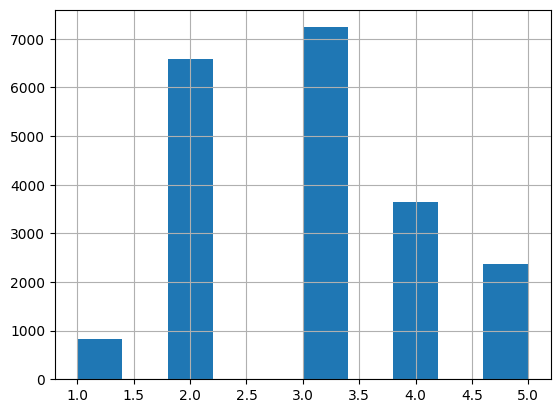

In [25]:
import numpy as np

housing["income_cat"] = pd.cut(housing["median_income"],
                              bins=[0.0, 1.5, 3.0, 4.5, 6.0, np.inf],
                              labels=[1, 2, 3, 4, 5])

housing["income_cat"].hist();

Now we are ready to do stratified sampling based on the income category. We will use Scikit-Learn's `StratefiedShuffleSplit` class:

In [26]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [27]:
strat_train_set

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,72100.0,INLAND,2
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,279600.0,NEAR OCEAN,5
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,82700.0,INLAND,2
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,112500.0,NEAR OCEAN,2
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,238300.0,<1H OCEAN,3
...,...,...,...,...,...,...,...,...,...,...,...
15174,-117.07,33.03,14.0,6665.0,1231.0,2026.0,1001.0,5.0900,268500.0,<1H OCEAN,4
12661,-121.42,38.51,15.0,7901.0,1422.0,4769.0,1418.0,2.8139,90400.0,INLAND,2
19263,-122.72,38.44,48.0,707.0,166.0,458.0,172.0,3.1797,140400.0,<1H OCEAN,3
19140,-122.70,38.31,14.0,3155.0,580.0,1208.0,501.0,4.1964,258100.0,<1H OCEAN,3


Let's check the income category proportions in this test set:

In [28]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

Let's compare the income category proportion in the overall dataset, in the test set generated with stratified sampling, and in a test set generated by using purely random sampling:

In [29]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42) # random split

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [30]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
income_cat,,,,,
1,0.039826,0.039971,0.040213,0.973236,0.364964
2,0.318847,0.318798,0.324370,1.732260,-0.015195
3,0.350581,0.350533,0.358527,2.266446,-0.013820
4,0.176308,0.176357,0.167393,-5.056334,0.027480
5,0.114438,0.114341,0.109496,-4.318374,-0.084674


As you can see, the test set generated using stratified sampling has income category proportions almost identical to those in the full dataset, whereas the test set generated using purely random sampling is quite skewed.

In [31]:
# Now we should remove the income_cat attribute so that
# the data is back to its original state
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

## Discover and Visualize the Data to Gain Insights
We have put the test set aside. Now we are going to explore the training set. Let's create a copy of the training set so that we can play with it without messing up the actual training set.

In [32]:
housing = strat_train_set.copy()

Now let's look at the housing prices by plotting. The radius of each circle represents the district's population (option `s`), and the color represents the price (option `c`). We use the color map (option `cmap`) called jet, which ranges from blue (low values) to red (high prices):

In [33]:
# Hannah will fix this later (lies - Hannah is too lazy) - Do not run this code

import matplotlib.image as mpimg
california_img=mpimg.imread('https://www.sjsu.edu/people/wendy.lee/pics/CS122/california.png')

ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       s=housing['population']/100, label="Population",
                       c="median_house_value", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.4,
                      )
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
plt.show()

ValueError: Please open the URL for reading and pass the result to Pillow, e.g. with ``np.array(PIL.Image.open(urllib.request.urlopen(url)))``.

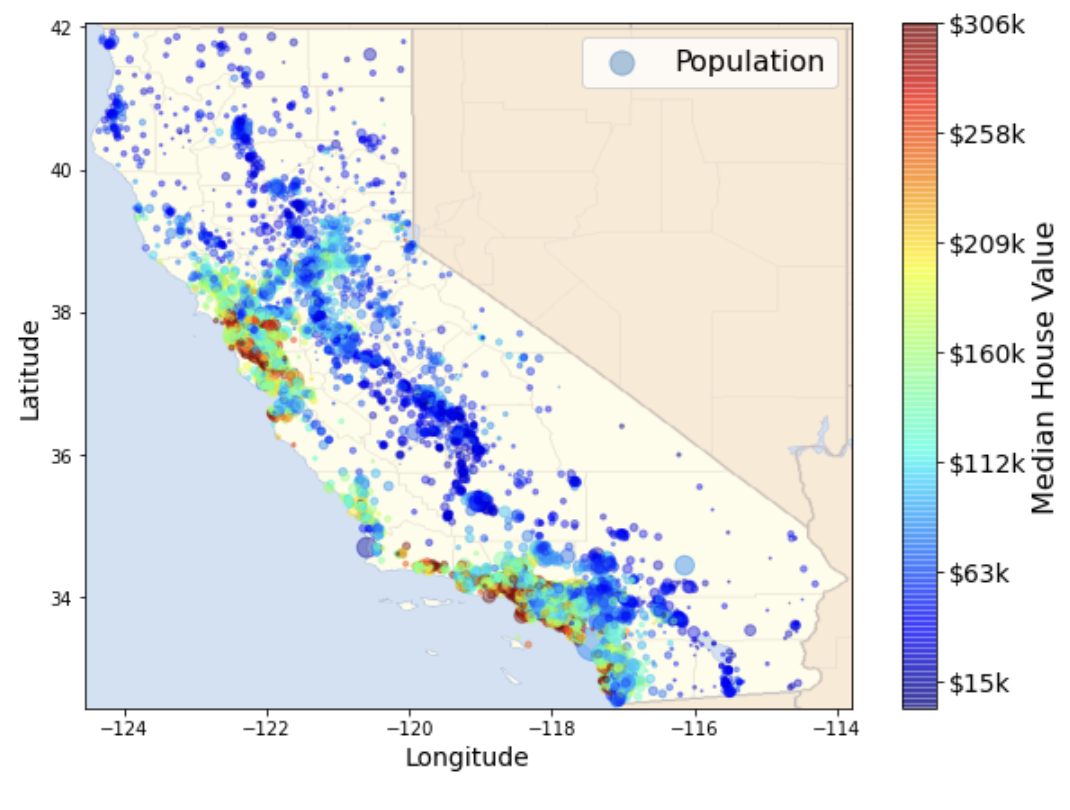

This image tells us that the housing prices are very much related to the location (e.g. close to the ocean) and the population density.

### Looking for Correlations
We can compute the *standard correlation coefficient* (also called *Pearson's r*) between every pair of attributes using the `corr()` method:

In [34]:
housing.drop("ocean_proximity", axis=1)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,72100.0
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,279600.0
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,82700.0
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,112500.0
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,238300.0
...,...,...,...,...,...,...,...,...,...
15174,-117.07,33.03,14.0,6665.0,1231.0,2026.0,1001.0,5.0900,268500.0
12661,-121.42,38.51,15.0,7901.0,1422.0,4769.0,1418.0,2.8139,90400.0
19263,-122.72,38.44,48.0,707.0,166.0,458.0,172.0,3.1797,140400.0
19140,-122.70,38.31,14.0,3155.0,580.0,1208.0,501.0,4.1964,258100.0


In [37]:
corr_matrix = housing.select_dtypes(include=[np.number]).corr()

<Axes: >

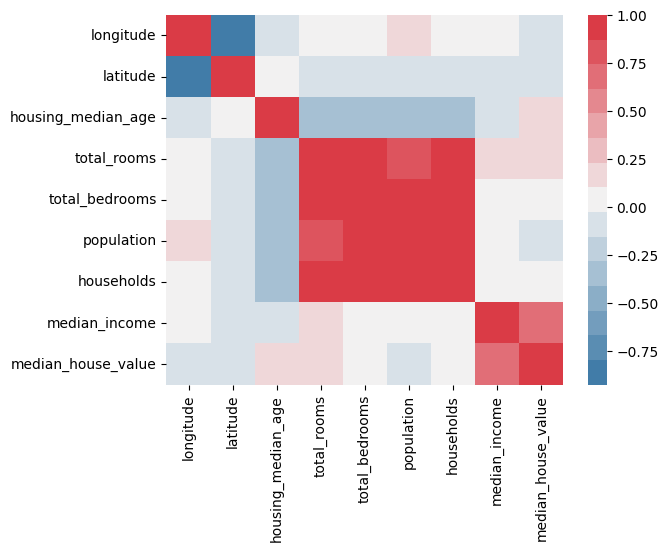

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(corr_matrix, cmap=sns.diverging_palette(240, 10, n=15))

In [40]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

**Note:** The correlation coefficient only measures linear correlations ("if x goes up, then y generally goes up/down"). It may completely missout on non-linear relationships) (e.g. "if x is close to zero then y generally goes up")

Another way of looking at correlation between attributes is to create a Seaborn pairplot.

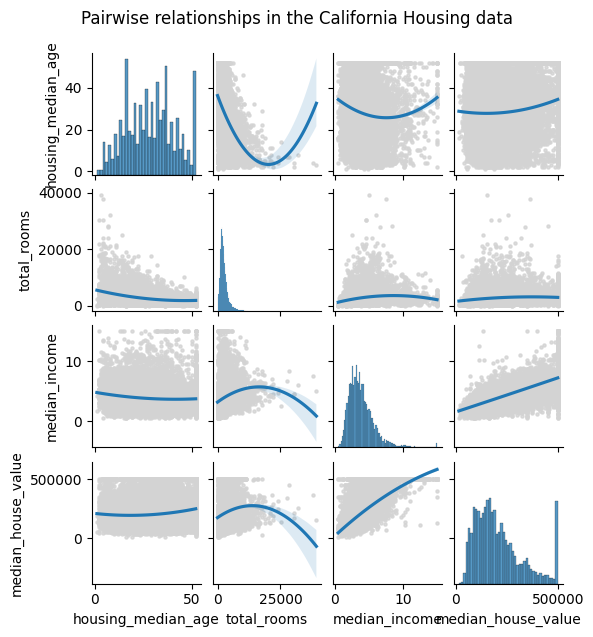

In [41]:
import seaborn as sns
g=sns.pairplot(
    data=housing.drop(['ocean_proximity','longitude','latitude','households','population','total_bedrooms'], axis=1),
    kind="reg", # regression
    plot_kws={"scatter_kws":{"color":"lightgrey", "s":5}, "order":2},
    height=1.5 # make the individual plots small
);
g.fig.suptitle(
    "Pairwise relationships in the California Housing data", y=1.05
);

The most promising attribute to predict the median house value is the median income, so let's zoom in on their correlation scatterplot:

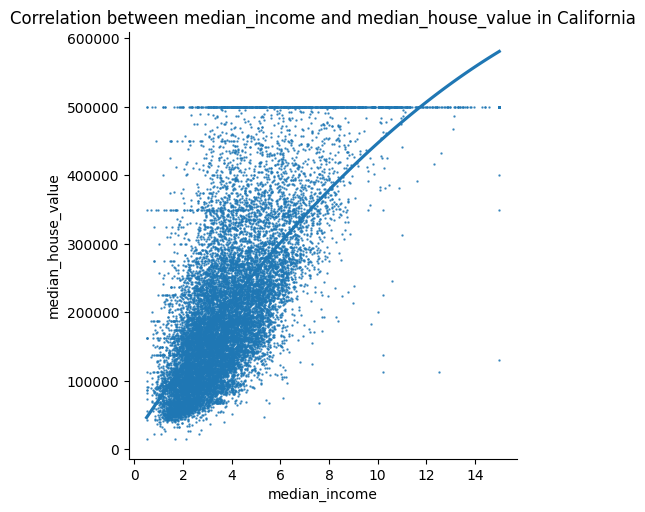

In [42]:
# Polymonial regression plot
sns.lmplot(
    data=housing,
    x="median_income",
    y="median_house_value",
    ci=None,
    order=2,
    markers='.',
    scatter_kws={'s':2}
)
plt.title(
"Correlation between median_income and median_house_value in California"
);

Here are a few observations:
1. The correlation is very strong; you can clearly see an upward trend and the points are not too dispersed.
2. The price cap that we noticed earlier is clearly visible as a horizontal line at \$500,000.
3. There are a few more obvious straight lines at \$450,000, \$350,000, and around \$280,000. We may want to remove the corresponding districts to prevent our algorithms from learning to reproduce these data quirks.

### Experimenting with Attribute Combinations
One last thing before we actually preparing the data for ML algorithms is to try out various attribute combinations.

For example: the total number of rooms in a district is not very useful if you don't know how many households there are. It makes more sense to look at the number of rooms per household. Similarly, the total number of bedrooms by itself is not very useful. It's more meaningful to look at number of bedrooms relative to the total number of rooms. Another interesting attribute would be population per household.

In [43]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]
housing["rooms_per_person"] = housing["total_rooms"]/housing["population"] # < - Added after data digestion!
# housing["people_per_room"] = housing["population"]/housing["total_rooms"] # < - Added after data digestion! (not as helpful?)
# housing["bedrooms_per_person"] = housing["total_bedrooms"]/housing["population"] # < - Added after data digestion! (also not helpful?)

In [44]:
corr_matrix = housing.drop("ocean_proximity", axis=1).corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687151
rooms_per_person            0.199420
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

The new `bedrooms_per_room` attribute is much more correlated with the `median house value` than the total number of rooms or bedrooms. Houses with a lower bedroom/room ratio tend to be more expensive. `rooms_per_household` is also more informative than the `total_rooms` in a district.

In [45]:
[col for col in corr_matrix.columns if col != "median_house_value"] + ["median_house_value"]

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'rooms_per_household',
 'bedrooms_per_room',
 'population_per_household',
 'rooms_per_person',
 'median_house_value']

In [46]:
corr_matrix = housing.drop("ocean_proximity", axis=1)[[col for col in corr_matrix.columns if col != "median_house_value"] + ["median_house_value"]].corr()

In [47]:
# orienting
# starting with a dataframe with too much information (all values look roughly like this: -0.021991)
# unimportant labels, too detailed, need to round

# Where I want to go
# in all columns except for median_house_value I want to have empty strings
# ONLY in the median_house_value column, I want to have ROUNDED values (-0.02)

# planning phase
# apply? - write a function
# maybe just general function

# executing phase
# bugs in my code

def show_only_correlations_related_to_median_housing_value(row):
  # reference old row and new row
  new_row_index = row.index
  # making empty stuff for all of the positions in the row
  new_row_values = ["" for i in range(len(row))]
  new_row = pd.Series(new_row_values, index=new_row_index)
  # make edits to new row and return new row
  new_row.median_house_value = str(round(row.median_house_value, 2))
  return new_row


# show_only_correlations_related_to_median_housing_value(pd.Series([1,2,3], index=["hi", "there", "median_house_value"]))

custom_annotation = corr_matrix.apply(show_only_correlations_related_to_median_housing_value, axis="columns")

In [48]:
pd.Series([1,2,3], index=["hi", "there", "you"]) # troubleshooting code

hi       1
there    2
you      3
dtype: int64

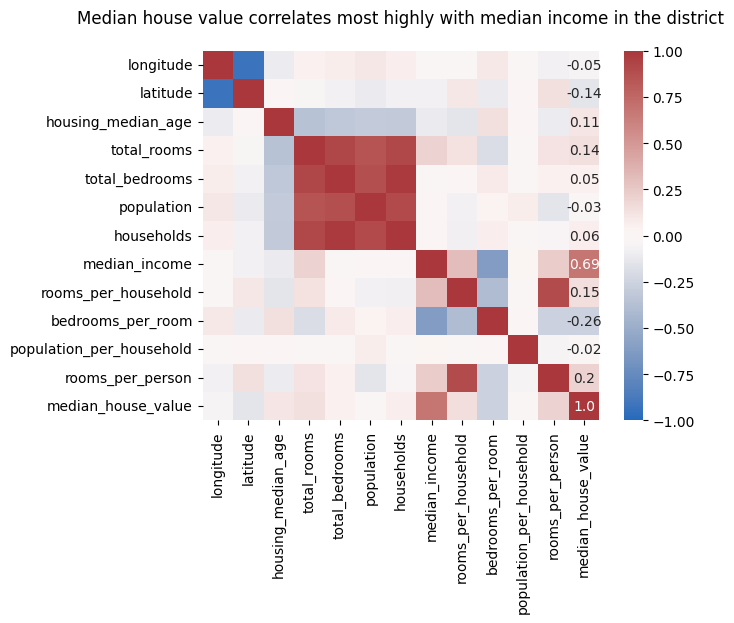

In [49]:
sns.heatmap(corr_matrix,
            # cmap=sns.diverging_palette(240, 10, n=15),
            cmap="vlag",
            vmax=1,
            vmin=-1,
            annot=custom_annotation,
            fmt="s")
plt.title("Median house value correlates most highly with median income in the district", pad=20);

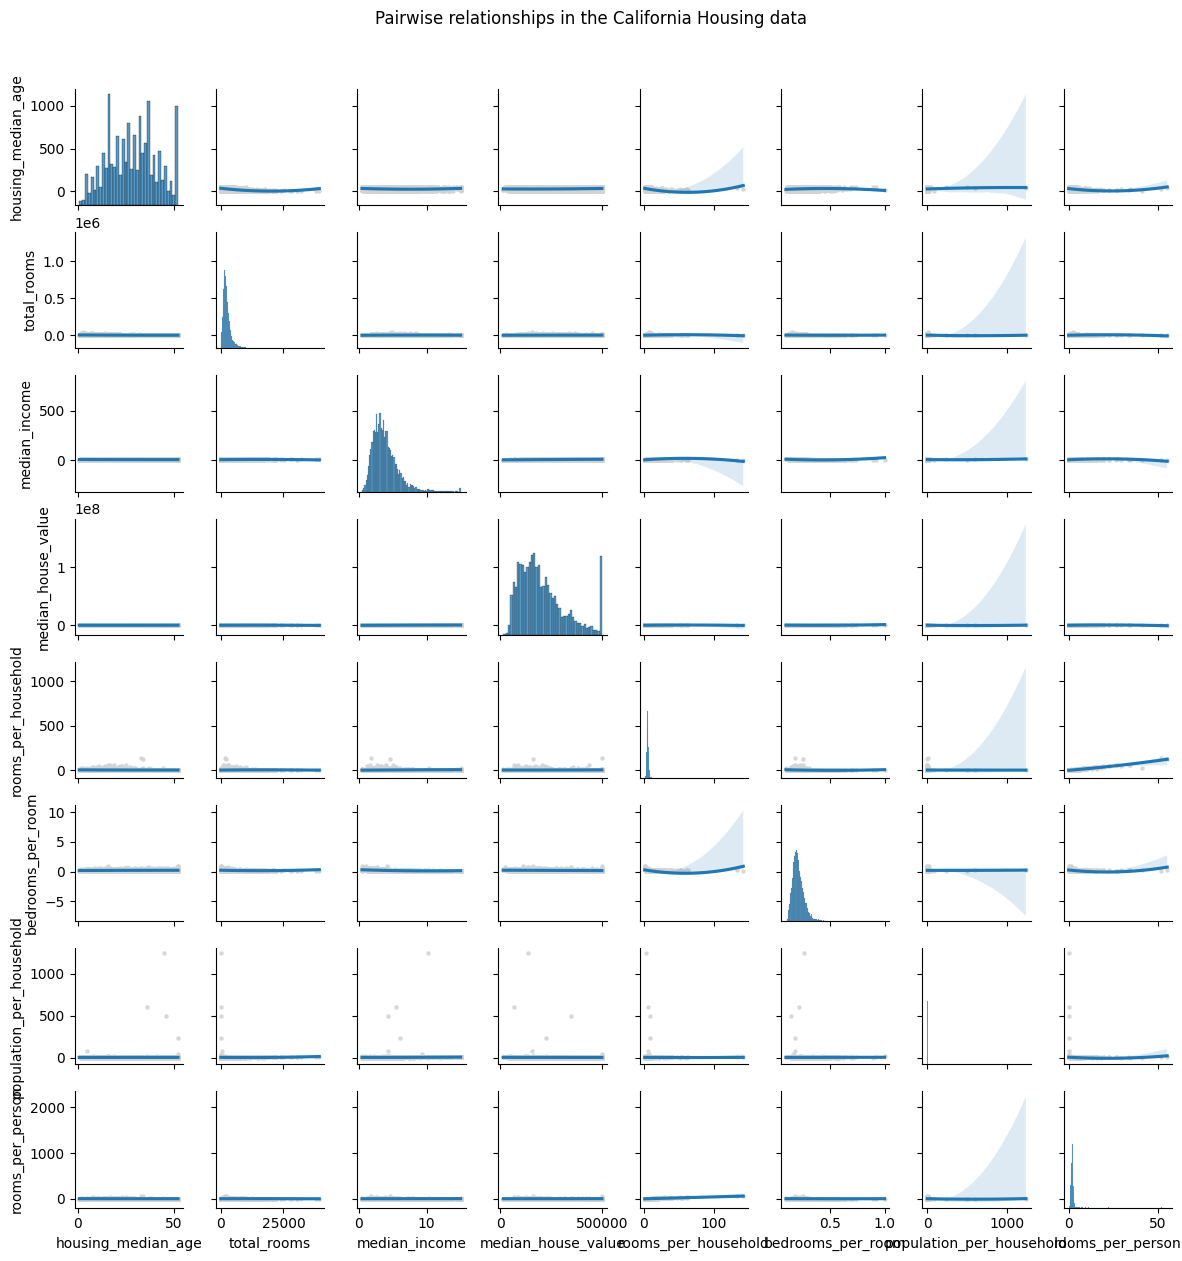

In [50]:
g=sns.pairplot(
    data=housing.drop(['ocean_proximity','longitude','latitude','households','population','total_bedrooms'], axis=1),
    kind="reg", # regression
    plot_kws={"scatter_kws":{"color":"lightgrey", "s":5}, "order":2},
    height=1.5 # make the individual plots small
);
g.fig.suptitle(
    "Pairwise relationships in the California Housing data", y=1.05
);